# Topic Classification of Stackoverflow questions
(This Project was done by Karthik Suresh)

The goal of this project is to predict the tags associated with a question from stackoverflow given the title of the question. The libraries used here includes Keras,NLTK,gensim,pandas and numpy to name a few.

The dataset used here is named full_dataset.csv from kaggle's ['Stackoverflow Question Classification Challenge'](https://www.kaggle.com/nazeboan/stackoverflow-questions-classification-challenge?select=full_dataset.csv)


First we download and import the csv file required into our working environment. in this case i am uploading the csv file from my local to the google colab runtime instance

In [4]:
from google.colab import files
files.upload()

Saving full_dataset.csv to full_dataset.csv


{'full_dataset.csv': b'title;id_stack;tags;views;score;done;label\nUsing entries from other kivy classes;61881920;[\'python\', \'python-3.x\', \'kivy\'];12;0;False;python\nPackage python software with pylucene dependency;61896481;[\'python\', \'docker\', \'pip\', \'dependencies\', \'pylucene\'];7;1;False;python\nExtracting time with regex from a string;61894597;[\'python\', \'regex\'];29;3;False;python\nHow do I add specific headers before each form in a model formset?;61896721;[\'python\', \'django\'];4;0;False;python\nBarplot from a dataframe using a column to set the bar colors;61896506;[\'python\', \'pandas\', \'bar-chart\', \'seaborn\', \'stacked-chart\'];12;0;True;python\npython how to collect a specific file from a list of folders and save;61278468;[\'python\', \'file\', \'file-io\'];43;1;True;python\n"&lt;select&gt; element is displayed with default value with dashes (---------), how to change it?";61896701;[\'python\', \'django\'];4;0;False;python\nMultiple GET Requests, merge

We then import the required modules and download the needed corpora from nltk


In [18]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn import preprocessing
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from time import sleep
import pandas as pd
import numpy as np
import nltk
import requests
import json
import re
import copy

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Here, i have defined some useful functions that will help in the preprocessing and prediction of targets

In [7]:
def sub_enescaped(questions):
  # this function helps in removing unnecesary html escape characters
  unescaped = get_unescaped_chars()
  for charr in unescaped:
    pattern = re.compile(charr)
    i=0
    while(i!=len(questions)):
      questions[i]=re.sub(pattern,"",questions[i])
      i+=1
  return questions

def clean_text(questions):

  #to replace numbers with the tag <num> using regex queries
  for idx,st in enumerate(questions):
    nums=re.findall('\d+', st)
    for num in nums:
      questions[idx]=questions[idx].replace(num,"<NUM>")

  #removing punctuation marks and tokenizing the sentence list using regex tokenizer
  tokenizer2 = nltk.RegexpTokenizer(r"\w+")
  filtered_sentence = [tokenizer2.tokenize(sentence.lower()) for sentence in questions]

  #removing stopwords using a stopword corpora from nltk
  stop_words = set(stopwords.words('english')) 
  i=0
  while(i<len(filtered_sentence)):
    for word in stop_words:
      if word in filtered_sentence[i]:
        filtered_sentence[i].remove(word)
    i+=1
  return filtered_sentence


def tokenize_sent(filtered_sentence):
  #this tokenizer is used to map text tokens to numerical values so that they can be fed as a key to the word vector matrix
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(filtered_sentence)
  tokenizer.word_index['unk'] = 0
  return tokenizer

def get_padded_data(filtered_sentence,tokenizer,max_length):
  #used to encode text using the tokenizer and then pre-pad the sequences to a uniform length so that it could be fed in a uniform shape to the input layer
  encoded_sentences = copy.deepcopy(filtered_sentence)
  for idx1,i in enumerate(filtered_sentence):
    for idx2,_ in enumerate(i):
      encoded_sentences[idx1][idx2] = tokenizer.word_index[encoded_sentences[idx1][idx2]]
  data = pad_sequences(encoded_sentences, maxlen=max_length,padding="pre", truncating="post")
  return data

def get_unescaped_chars():
  #list of unescaped html characters
  unescaped = [r"&lt;",	r"&#60;",r"&gt;",	r"&#62;",r"&amp;",r"&#38;",r"&quot;",r"&#34;",
                r"&apos;"	,r"&#39;", r"&cent;"	,r"&#162;", r"&pound;"	,r"&#163;", r"&yen;"	,r"&#165;",
    r"&euro;",	r"&#8364;",
    r"&copy;",	r"&#169;",
    r"&reg;"	,r"&#174;"]
  return unescaped


def predict_tag(query,n):
  #removing unnecesary html escape characters
  unescaped = get_unescaped_chars()
  for charr in unescaped:
    pattern = re.compile(charr)
    query=re.sub(pattern,"",query)
  #cleaning the text
  cleaned = clean_text([query])
  for idx1,i in enumerate(cleaned):
    for idx2,k in enumerate(i):
      if k not in tokenizer.word_index.keys():
        cleaned[idx1][idx2] = 'unk'
  query_data = get_padded_data(cleaned,tokenizer,max_length)
  #prediction probablity of each class
  y_proba = model.predict(query_data)

  # converting the numpy array into a more concise formated list
  prob_list = np.squeeze(y_proba).tolist()

  # sorting the probabilities in descending order
  sorted_l = sorted(prob_list, reverse=True)

  # extracting the top n probabilities
  temp = []
  for t in sorted_l[:n]:
      for idx, i in enumerate(prob_list):
          if i == t:
              temp.append(idx)

  # reverse encoding of the probabilities into their respective labels
  final_list = le.inverse_transform(temp).tolist()
  return final_list

Now, we load the csv into a dataframe and proceed to extract the questions along with the associated tags. You can see how a sentence with unescaped characters changes in the output box.

In [29]:
data_frame = pd.read_csv('full_dataset.csv', sep=';')

tags=[]
questions=[]
for li in data_frame['tags']:
    tags.append(eval(li))

for i in data_frame['title']:
    questions.append(i)
print(questions[6])
questions = sub_enescaped(questions)
print(questions[6])

&lt;select&gt; element is displayed with default value with dashes (---------), how to change it?
select element is displayed with default value with dashes (---------), how to change it?


from the tags we have we want to select only the very frequent tags and drop the rest.This is because, when the frequency of the tag occurence is less, the model cannot generalize well for that label as it has not trainined on enough counts of that particular label. So, here we are dropping all the tags which have their unique counts across the list as less than 500

In [36]:
target_counts = {}
rejected_targets = []
accepted_targets = []
f=0

for i in tags:
  for j in i:
    if j not in target_counts.keys():
      target_counts[j]=1
    else:
      target_counts[j]+=1

for key in target_counts.keys():
  if target_counts[key]<500:
    rejected_targets.append(key)
  else:
    accepted_targets.append(key)

while(f<=3):
  for i,t in enumerate(tags):
    for j,k in enumerate(t):
      if k in rejected_targets:
        tags[i].remove(k)
  f+=1
print("Number of unique targets after removing less frequent labels: "+str(len(accepted_targets)))

Number of unique targets after removing less frequent labels: 20


Here, we make the final lists to be used by essentially flattening the components into a 1D array

In [38]:
final_tag_list=[]
final_question_list=[]

for idx,i in enumerate(tags):
  t=0
  while(t<len(i)):
      final_tag_list.append(i[t])
      final_question_list.append(questions[idx])
      t+=1
print('length of tag list: '+str(len(final_tag_list)))
print('length of question list: '+str(len(final_tag_list)))

length of tag list: 41359
length of question list: 41359


This next block of code uses the functions defined in the starting to clean the text and tokenize it appropriately. the final output data comes out to be of dimension *num_of_questions x max_length_of_sentence*.


In [41]:
filtered_sentence = clean_text(final_question_list)
tokenizer = tokenize_sent(filtered_sentence)
max_length = max([len(i) for i in filtered_sentence])
data = get_padded_data(filtered_sentence,tokenizer,max_length)
print(data[100])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  156   53 1926  164  148
  546  148    2  454]


Here, we train Word2Vec Embeddings (Word2vec is a method of computing vector representations of words introduced by a team of researchers at Google led by Tomas Mikolov) on the tokenized sentences and store the word vectors for later use

In [14]:
vec_model = Word2Vec(filtered_sentence, size=100, window=3, min_count=1)
word_vectors = vec_model.wv

Then, we use sklearns *LabelEncoder()* function to encode the targets and store it into a numpy array y after fitting and transforming

In [47]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(final_tag_list)
print(y[:10])

[14 15 14 14 14 14 12 14 14 14]


We now take the word vectors trained from the Word2Vec model and create *wv_matrix* to store the vector representations of each word at appropriate indices provided by the keras tokenizer we had fit before

In [54]:
WV_DIM = 100
nb_words = len(tokenizer.word_index)
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word,i in tokenizer.word_index.items():
  if i >= nb_words:
      continue
  try:
    embedding_vector = word_vectors[word]
    # words not found in embedding index will be all-zeros.
    wv_matrix[i] = embedding_vector
  except:
    wv_matrix[i] = np.zeros((WV_DIM,))

We now start to build the Keras model. 

First, the metric to be used is defined. 



*   the **SparseTopKCategoricalAccuracy** metric Computes how often the true targets are in the top K predictions. Here, i have used a SparseTopKCategoricalAccuracy object with k=3 (i.e it will cheack the top 3 predictions for the target)

Next, we come to the model itself

*   *wv_layer* is initialized as an **Embedding** layer that takes as its weights the *wv_matrix* and enables training of the word embeddings during runtime
*   *comment_input* acts as an **Input** layer and takes in the vectors of shape (*max_length*,)
*   embedded_sequences passes the inputs taken through the *Input* layer (*comment_input*) and passes it on to the *Embedding* layer (*wv_layer*)
*   the **SpatialDropout1D** layer helps in dropout of 1D feature maps instead of individual elements
*   The output of that layer is passed on to an LSTM block with 64 hidden units
*   It then goes through a **Dropout** layer followed by a **BatchNormalization** layer
*   The final layer is the **Dense** layer with softmax activation having dimensionality of its output space equal to the number of uniques targets (length of *accepted_targets*,)
*   We finally compile the model using Adam optimizer (*Diederik et al. 2014*)








In [73]:
top3 = keras.metrics.SparseTopKCategoricalAccuracy(k=3)
wv_layer = Embedding(len(tokenizer.word_index),100,mask_zero=False,weights=[wv_matrix],input_length=max_length,trainable=True)

# Inputs
comment_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# LSTM
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = LSTM(64, return_sequences=False)(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(len(accepted_targets), activation='softmax')(x)

# Model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=[top3])
print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 32, 100)           1594800   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 32, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1300

We proceed to fit the data using **Early Stopping** along with a **Validation split** of 10%, **Mini batch** size of 512 and **Number of epochs** as 50

In [56]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_sparse_top_k_categorical_accuracy', patience=2)
hist = model.fit(data, y,epochs=50, batch_size=512, shuffle=True,callbacks=[early_stop],validation_split=0.1,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 37223 samples, validate on 4136 samples
Epoch 1/50
37223/37223 [==============================] - 19s 503us/step - loss: 2.6602 - sparse_top_k_categorical_accuracy: 0.3439 - val_loss: 2.5419 - val_sparse_top_k_categorical_accuracy: 0.4798
Epoch 2/50
37223/37223 [==============================] - 18s 485us/step - loss: 1.9603 - sparse_top_k_categorical_accuracy: 0.5428 - val_loss: 2.1018 - val_sparse_top_k_categorical_accuracy: 0.5931
Epoch 3/50
37223/37223 [==============================] - 18s 484us/step - loss: 1.6089 - sparse_top_k_categorical_accuracy: 0.6272 - val_loss: 1.8619 - val_sparse_top_k_categorical_accuracy: 0.6564
Epoch 4/50
37223/37223 [==============================] - 18s 488us/step - loss: 1.3799 - sparse_top_k_categorical_accuracy: 0.6805 - val_loss: 1.7398 - val_sparse_top_k_categorical_accuracy: 0.7016
Epoch 5/50
37223/37223 [==============================] - 18s 487us/step - loss: 1.2261 - sparse_top_k_categorical_accuracy: 0.7191 - val_loss: 1.6243 - va

The next two block are dedicated to finding the Training as well as the Validation accuracies and plotting them. As we can observe, the accuracy is pretty high (90%+) and the validation accuracy is also very close to it suggesting less overfitting of data, which is good!

In [66]:
print('Training accuracy: '+str(round(hist.history["sparse_top_k_categorical_accuracy"][-1],5)))
print('Validation accuracy: '+str(round(hist.history["val_sparse_top_k_categorical_accuracy"][-1],5)))

Training accuracy: 0.92186
Validation accuracy: 0.92217


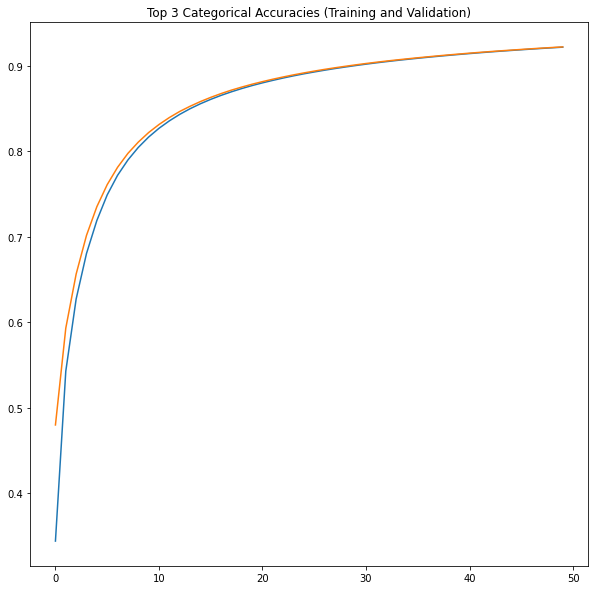

In [67]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(10,10));
plt.plot(history["sparse_top_k_categorical_accuracy"]);
plt.plot(history["val_sparse_top_k_categorical_accuracy"]);
plt.title("Top 3 Categorical Accuracies (Training and Validation)");
plt.show();

To see the model in action, I have used the Stackexchange API to query new questions from the website itself, based on the tags we already have, and see how well the model does in predicting the tags.

In [71]:
test_tags=[]
test_questions=[]
for class_name in le.classes_:
  sleep(1)
  page = requests.get("https://api.stackexchange.com//2.2/questions?pagesize=10&order=desc&sort=week&tagged="+class_name+"&site=stackoverflow")
  testQ = page.json()
  for item in testQ["items"]:
      test_tags.append(item['tags'])
      test_questions.append(item["title"])



In [75]:
for q,t in zip(test_questions,test_tags):
  print(sub_enescaped([q])[0])
  print('Top-'+str(len(t))+' predictions: '+str(predict_tag(q,len(t)))+" Actual Tags: "+str(t))
  print('\n')

onStop being called after onDestroy?
Top-3 predictions: ['javascript', 'dataframe', 'python-3.x'] Actual Tags: ['android', 'broadcastreceiver', 'android-lifecycle']


How does my activity run smoothly with lots of High Quality Images in Android?
Top-1 predictions: ['javascript'] Actual Tags: ['android']


Setting small icon in Notification above lollipop version
Top-5 predictions: ['javascript', 'dataframe', 'python-3.x', 'java', 'jquery'] Actual Tags: ['android', 'firebase', 'push-notification', 'firebase-cloud-messaging', 'heads-up-notifications']


WebRTC Android: sound from phone speaker is going into conference through phone mic and causing echo
Top-4 predictions: ['javascript', 'dataframe', 'python-3.x', 'jquery'] Actual Tags: ['android', 'webrtc', 'microphone', 'webrtc-android']


Android Studio Display Long in Button Text
Top-4 predictions: ['javascript', 'python-3.x', 'java', 'dataframe'] Actual Tags: ['java', 'android', 'xml', 'android-studio']


How to get last listview stat

We can see that from a lot of these predictions, the model is actually able to get a fair idea of what classes to categorize the questions. But there are still some issues pertaining to classes that are not present in the training but appear in the actual tags. But overall, I feel that this model is able to encapsule the meaning of the questions and predict relevant tags dynamically. Further work in this area could include using similar models and a bigger dataset to include more labels. 

An application of this project would be in stackoverflow itself. When the user is typing out the question, the model can dynamically suggest certain tags based on the wording of the question and can thus serve as an auxilliary tool.

# Thanks for Reading! Hope this interested you!
